In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt
import albumentations as albu

In [2]:
PATH_TO_DATA = '../data/'

In [3]:
os.listdir(PATH_TO_DATA)

['train_rec_without_persp.json',
 'test',
 '.ipynb_checkpoints',
 'train_rec.json',
 'train_mask.json',
 'submission.csv',
 'train.json',
 'train']

In [4]:
os.listdir(PATH_TO_DATA + 'train')[0]

'14451.jpg'

In [5]:
with open(PATH_TO_DATA + 'train.json') as fin:
    train_json = json.load(fin)
with open(PATH_TO_DATA + 'train_mask.json') as fin:
    train_mask = json.load(fin)
with open(PATH_TO_DATA + 'train_rec.json') as fin:
    train_rec = json.load(fin)

In [6]:
img = cv2.imread(PATH_TO_DATA + train_mask[0]['file'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_mask = cv2.imread(PATH_TO_DATA + train_mask[0]['mask'], cv2.IMREAD_GRAYSCALE)
img_rec = cv2.imread(PATH_TO_DATA + train_rec[0]['file'])

In [31]:
from sys import getsizeof

In [32]:
getsizeof(img)

7257932

In [36]:
img_scaled = img / 255.

In [48]:
for i in img_scaled:
    for j in i:
        for k in j:
            print(k)
            print(len(str(k)))
            break
        break
    break

0.48627450980392156
19


In [42]:
getsizeof(img_scaled.astype(np.float32))

29031344

In [39]:
img_scaled.dtype

dtype('float64')

In [35]:
type(img / 255.)

numpy.ndarray

In [11]:
rotator = albu.Rotate()

In [24]:
aug = rotator(image=img, mask=img_mask)

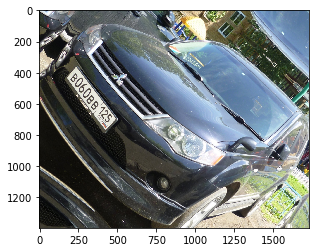

In [25]:
plt.imshow(aug['image'])

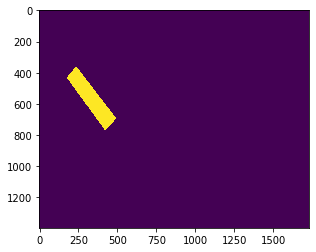

In [26]:
plt.imshow(aug['mask'])

In [68]:
img_mask = (img_mask > 1).astype(np.uint8)

In [ ]:
img_mask

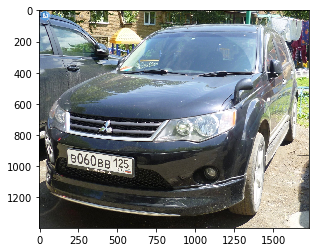

In [7]:
plt.imshow(img)

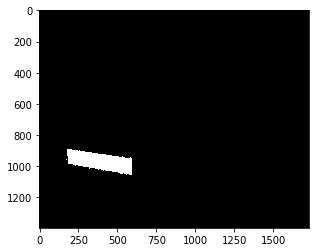

In [69]:
plt.imshow(img_mask, "Greys_r")

In [9]:
from detection.transform import *

In [10]:
train_transforms = Compose([
        Crop(min_size=1 - 1 / 3., min_ratio=1.0, max_ratio=1.0, p=0.5),
        Flip(p=0.05),
        Pad(max_size=0.6, p=0.25),
        Resize(size=(256, 256), keep_aspect=True),
        ScaleToZeroOne(256),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [19]:
def prepare_for_inference(image, fit_size):
    """
    Scale proportionally image into fit_size and pad with zeroes to fit_size
    :return: np.ndarray image_padded shaped (*fit_size, 3), float k (scaling coef), float dw (x pad), dh (y pad)
    """
    # pretty much the same code as detection.transforms.Resize
    h, w = image.shape[:2]
    k = fit_size[0] / max(w, h)
    image_fitted = cv2.resize(image, dsize=None, fx=k, fy=k)
    h_, w_ = image_fitted.shape[:2]
    dw = (fit_size[0] - w_) // 2
    dh = (fit_size[1] - h_) // 2
    image_padded = cv2.copyMakeBorder(image_fitted, top=dh, bottom=dh, left=dw, right=dw,
                                      borderType=cv2.BORDER_CONSTANT, value=0.0)
    if image_padded.shape[0] != fit_size[1] or image_padded.shape[1] != fit_size[0]:
        image_padded = cv2.resize(image_padded, dsize=fit_size)
    return image_padded, k, dw, dh

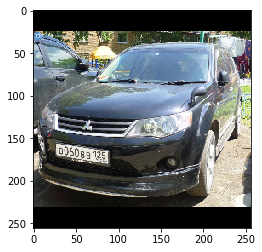

In [25]:
plt.imshow(prepare_for_inference(img.astype(np.float) / 255., (256, 256))[0])

In [11]:
img_tr, img_mask_tr = train_transforms(img, img_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


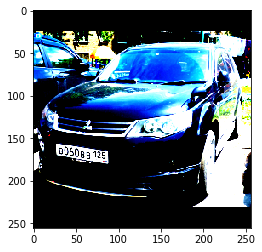

In [12]:
plt.imshow(img_tr)

In [ ]:
import segmentation_models_pytorch as smp

In [27]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=2)

# Recognition

In [1]:
from torchvision import models

In [8]:
resnet = getattr(models, 'se_resnet50')(pretrained=True)

AttributeError: module 'torchvision.models' has no attribute 'se_resnet50'

In [52]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
from torch import nn

In [77]:
extractor = nn.Sequential(*list(resnet.children())[:-2])

In [55]:
extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [57]:
extractor

<generator object Module.children at 0x7f2508333ed0>

In [58]:
mobilenet = getattr(models, 'mobilenet_v2')(pretrained=True)

In [59]:
mobilenet

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [99]:
extractor_mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])

In [19]:
import torch
from recognition.transform import Resize

In [11]:
resize = Resize()

In [12]:
resized_img_rec = resize({'image':img_rec})['image']

In [13]:
img_rec_for_model = torch.from_numpy(resized_img_rec.transpose(2, 0, 1).astype(np.float32)).unsqueeze(0)

In [14]:
img_rec_for_model.shape

torch.Size([1, 3, 32, 320])

In [100]:
result_resnet = extractor(img_rec_for_model)

In [101]:
result_resnet.shape

torch.Size([1, 512, 1, 10])

In [102]:
result_mobilenet = extractor_mobilenet(img_rec_for_model)

In [103]:
result_mobilenet.shape

torch.Size([1, 1280, 1, 10])

In [2]:
resnet34 = getattr(models, 'resnet34')(pretrained=True)

In [ ]:
torch.nn.BatchNorm1d()

In [17]:
extractor_resnet34 = nn.Sequential(*list(resnet34.children())[:-2])

In [18]:
extractor_resnet34(img_rec_for_model).shape

torch.Size([1, 512, 1, 10])

In [109]:
densenet121 = getattr(models, 'densenet121')(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/ubuntu/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [119]:
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [111]:
extractor_densenet121 = nn.Sequential(*list(resnet34.children())[:-1])

In [112]:
extractor_densenet121(img_rec_for_model).shape

torch.Size([1, 512, 1, 1])